# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Необходимо исследовать данные и сделать выводы по полученным результатам. Подкрепить свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверить, являются ли выводы статистически значимыми.

В процессе своего анализа следует:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    *   Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    *   Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    *   Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    *   Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
3. Отметить в анализе иные интересные закономерности, если они будут найдены.
4. Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:
    *   тесты для количественного признака:
        *   для одной выборки;
        *   для двух выборок;
        *   для нескольких выборок;
    *   тест для категориальных признаков.

В проекте будет выбран уровень значимости $\alpha=0.05$.

## Описание исходных данных

Ответить на эти вопросы нам помогут данные:

*   work_year — Год, в котором была выплачена зарплата.
*   experience_level — Опыт работы на этой должности в течение года со следующими возможными значениями:
    *   EN — Entry-level/Junior;
    *   MI — Mid-level/Intermediate;
    *   SE — Senior-level/Expert;
    *   EX — Executive-level/Director.
*   employment_type —	Тип трудоустройства для этой роли:
    *   PT — неполный рабочий день;
    *   FT — полный рабочий день;
    *   CT — контракт;
    *   FL — фриланс.
*   job_title — Роль, в которой соискатель работал в течение года.
*   salary — Общая выплаченная валовая сумма заработной платы.
*   salary_currency — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
*   salary_in_usd — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
*   employee_residence — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
*   remote_ratio — Общий объём работы, выполняемой удалённо. Возможные значения:
    *   0 — удалённой работы нет (менее 20 %);
    *   50 — частично удалённая работа;
    *   100 — полностью удалённая работа (более 80 %).
*   company_location — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   company_size — Среднее количество людей, работавших в компании в течение года:
    *   S — менее 50 сотрудников (небольшая компания);
    *   M — от 50 до 250 сотрудников (средняя компания);
    *   L — более 250 сотрудников (крупная компания).

Источник датасета: ["Data Science Job Salaries" (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries/)

## Загрузка данных

In [2]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [3]:
# загружаем датасет
data = pd.read_csv('./ds_salaries.csv')
data.head()

Unnamed: 0  work_year experience_level employment_type  \
0           0       2020               MI              FT   
1           1       2020               SE              FT   
2           2       2020               SE              FT   
3           3       2020               MI              FT   
4           4       2020               SE              FT   

                    job_title  salary salary_currency  salary_in_usd  \
0              Data Scientist   70000             EUR          79833   
1  Machine Learning Scientist  260000             USD         260000   
2           Big Data Engineer   85000             GBP         109024   
3        Product Data Analyst   20000             USD          20000   
4   Machine Learning Engineer  150000             USD         150000   

  employee_residence  remote_ratio company_location company_size  
0                 DE             0               DE            L  
1                 JP             0               JP            S  
2                 GB            50               GB            M  
3                 HN             0               HN            S  
4                 US            50               US            L

In [4]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений). Проверим данные на наличие полных дубликатов:

In [6]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


Дубликатов нет. Разберёмся с лишними колонками. Отметим, что первая колонка "Unnamed: 0" представляет собой просто порядковый номер строки, её следует удалить. Кроме того, для анализа не нужны зарплаты в национальной валюте и признак самой валюты, поскольку мы уже имеем данные о зарплатах в USD.

In [7]:
data.drop(['Unnamed: 0','salary','salary_currency'], axis=1, inplace=True)

Признаки с ограниченным набором значений лучше преобразовать в категориальные. К их числу относится и признак remote_ratio. Формально это число, но из описания задачи ясно, что это по сути категориальный признак, имеющий всего три возможных значения (0, 50, 100). Аналогичная ситуация и с годом (work_year), поэтому его тоже преобразуем в категориальный. Дополнительно для тех признаков, для которых это имеет смысл, зададим порядок категорий.

In [8]:
data['experience_level'] = data['experience_level'].astype('category')
data['employment_type'] = data['employment_type'].astype('category')
data['remote_ratio'] = data['remote_ratio'].astype('category')
data['company_size'] = data['company_size'].astype('category')
data['work_year'] = data['work_year'].astype('category')

data['experience_level'] = data['experience_level'].cat.set_categories(
    ['EN', 'MI', 'SE', 'EX'], ordered=True
)

data['company_size'] = data['company_size'].cat.set_categories(
    ['S', 'M', 'L'], ordered=True
)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           607 non-null    category
 1   experience_level    607 non-null    category
 2   employment_type     607 non-null    category
 3   job_title           607 non-null    object  
 4   salary_in_usd       607 non-null    int64   
 5   employee_residence  607 non-null    object  
 6   remote_ratio        607 non-null    category
 7   company_location    607 non-null    object  
 8   company_size        607 non-null    category
dtypes: category(5), int64(1), object(3)
memory usage: 22.8+ KB


Отметим, что объём использованной памяти сократился более чем вдвое. Оставшиеся признаки типа object нет особого смысла переводить в category из-за большого разнообразия значений.

### Распределение заработной платы в USD для всех сотрудников

Получим основные статистические характеристики для признака salary_in_usd, а также посмотрим на распределение этого признака:

In [9]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплаты в USD']
data_agg

Размер зарплаты в USD
count                 607.00
mean               112297.87
std                 70957.26
min                  2859.00
25%                 62726.00
50%                101570.00
75%                150000.00
max                600000.00

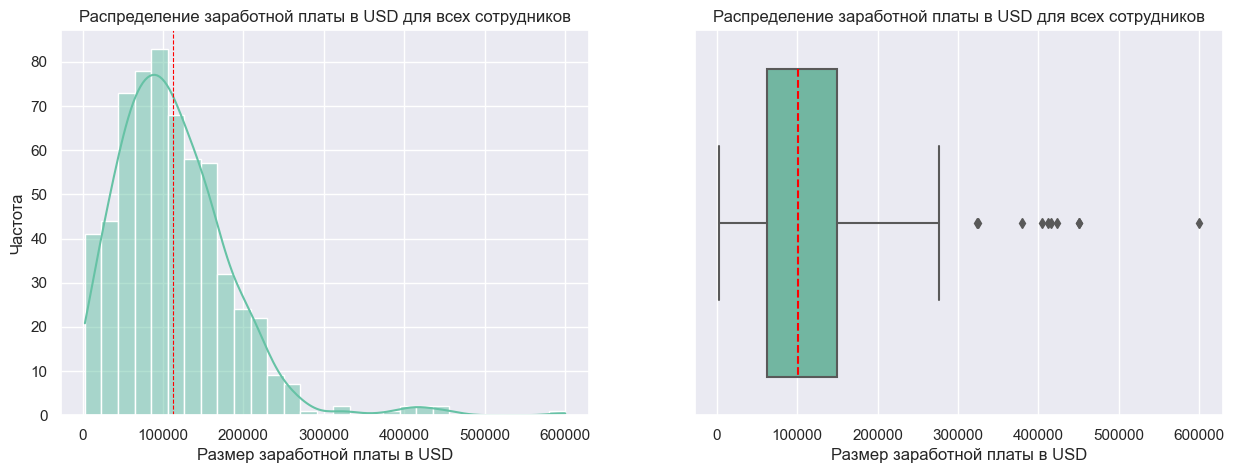

In [10]:
# строим гистограмму распределения заработной платы в USD и одновременно boxplot для большей наглядности
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data, x='salary_in_usd', kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы в USD', ylabel='Частота')
axes[0].set_title('Распределение заработной платы в USD для всех сотрудников')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data, x='salary_in_usd', ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Размер заработной платы в USD')
axes[1].set_title('Распределение заработной платы в USD для всех сотрудников')

plt.show()

Распределение заработной платы в USD отлично от нормального, имеются выбросы. Наличие выбросов подсказывает нам, что для изучения лучше использовать медиану (median), а не среднее (mean), поскольку медиана менее чувствительна к выбросам.

### Диаграммы для категориальных признаков

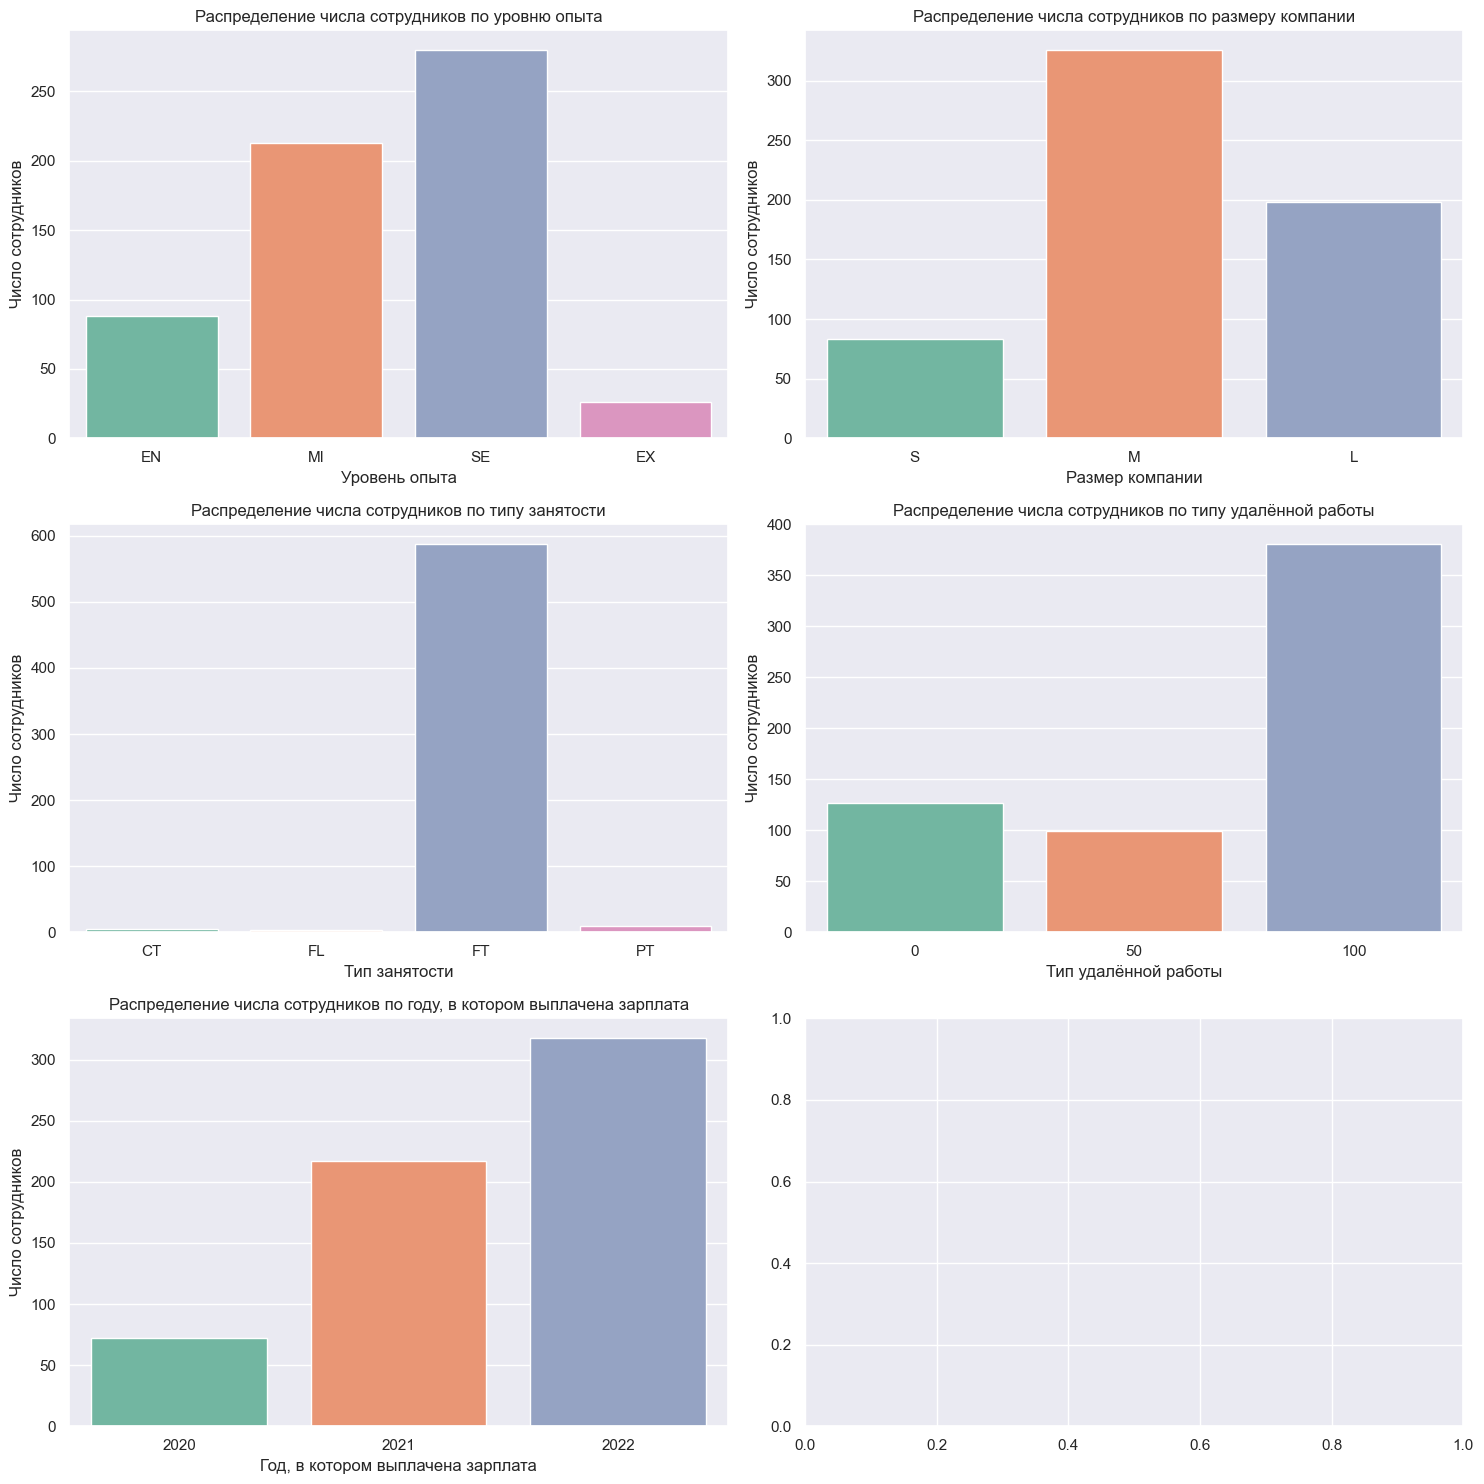

In [13]:
# строим диаграммы распределения по уровню опыта, размеру компании, типу занятости, типу удалённой работы, году
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

sns.countplot(data, x='experience_level', ax=axes[0,0])
axes[0,0].set(xlabel='Уровень опыта', ylabel='Число сотрудников')
axes[0,0].set_title('Распределение числа сотрудников по уровню опыта')

sns.countplot(data, x='company_size', ax=axes[0,1])
axes[0,1].set(xlabel='Размер компании', ylabel='Число сотрудников')
axes[0,1].set_title('Распределение числа сотрудников по размеру компании')

sns.countplot(data, x='employment_type', ax=axes[1,0])
axes[1,0].set(xlabel='Тип занятости', ylabel='Число сотрудников')
axes[1,0].set_title('Распределение числа сотрудников по типу занятости')

sns.countplot(data, x='remote_ratio', ax=axes[1,1])
axes[1,1].set(xlabel='Тип удалённой работы', ylabel='Число сотрудников')
axes[1,1].set_title('Распределение числа сотрудников по типу удалённой работы')

sns.countplot(data, x='work_year', ax=axes[2,0])
axes[2,0].set(xlabel='Год, в котором выплачена зарплата', ylabel='Число сотрудников')
axes[2,0].set_title('Распределение числа сотрудников по году, в котором выплачена зарплата')

plt.tight_layout()
plt.show()

Чтобы построить распределение вакансий по оставшимся признакам (название роли, страна проживания сотрудника, страна регистрации компании), применим приём с выделением top 10 категорий (в противном случае из-за большого разнообразия значений мы получим длинный "хвост", который будет неудобен для анализа).

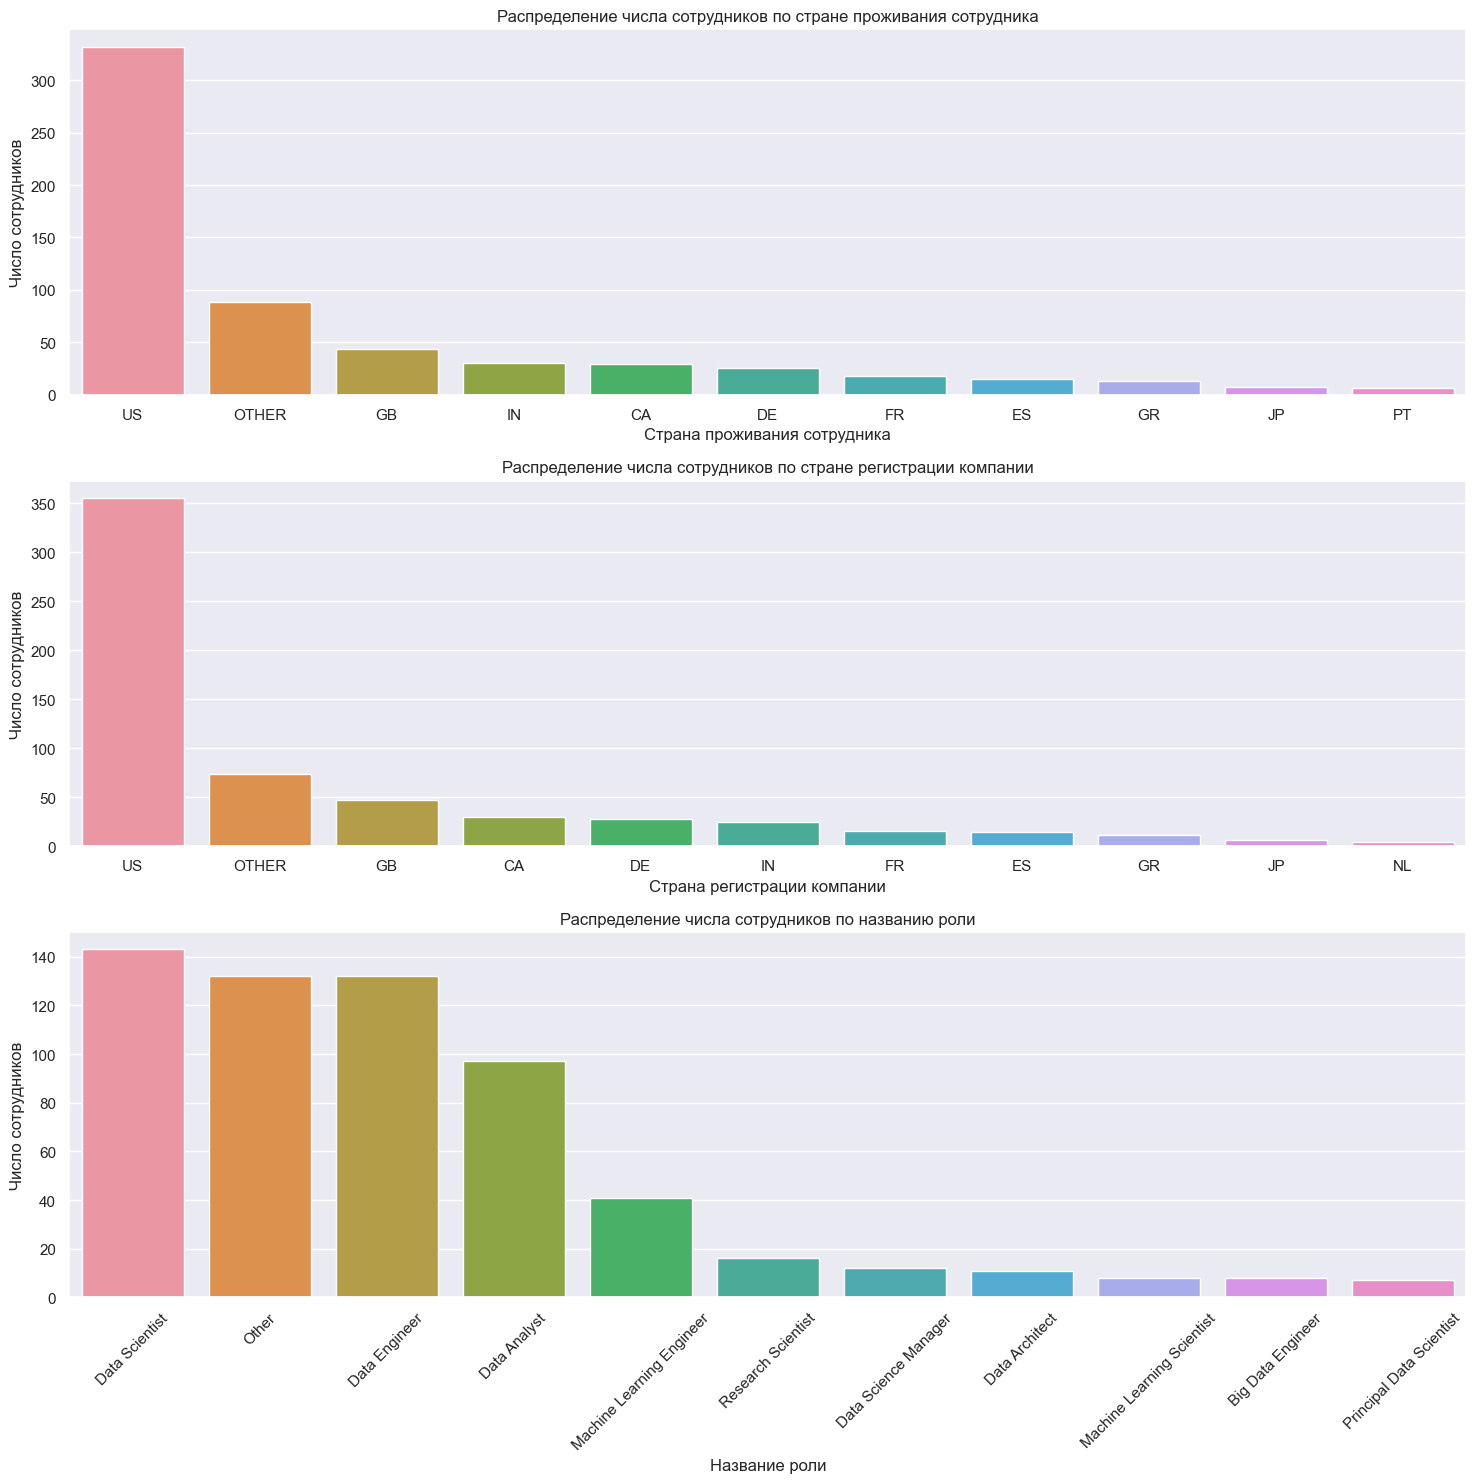

In [14]:
# подсчитываем значения в каждом поле
count_employee_residence = data['employee_residence'].value_counts()
count_company_location = data['company_location'].value_counts()
count_job_title = data['job_title'].value_counts()

# выделяем top 10
top_10_employee_residences = count_employee_residence.nlargest(10).index
top_10_company_locations = count_company_location.nlargest(10).index
top_10_job_titles = count_job_title.nlargest(10).index

# в остальных записях заменяем страну / название роли на Other
data['employee_residence_top_10'] = data['employee_residence'].apply(lambda x: x if x in top_10_employee_residences else 'OTHER')
data['company_location_top_10'] = data['company_location'].apply(lambda x: x if x in top_10_company_locations else 'OTHER')
data['job_title_top_10'] = data['job_title'].apply(lambda x: x if x in top_10_job_titles else 'Other')

# строим диаграммы
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

sns.countplot(data, x='employee_residence_top_10', order=data['employee_residence_top_10'].value_counts().index, ax=axes[0])
axes[0].set(xlabel='Страна проживания сотрудника', ylabel='Число сотрудников')
axes[0].set_title('Распределение числа сотрудников по стране проживания сотрудника')

sns.countplot(data, x='company_location_top_10', order=data['company_location_top_10'].value_counts().index, ax=axes[1])
axes[1].set(xlabel='Страна регистрации компании', ylabel='Число сотрудников')
axes[1].set_title('Распределение числа сотрудников по стране регистрации компании')

sns.countplot(data, x='job_title_top_10', order=data['job_title_top_10'].value_counts().index, ax=axes[2])
axes[2].set(xlabel='Название роли', ylabel='Число сотрудников')
axes[2].set_title('Распределение числа сотрудников по названию роли')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Оценка влияния факторов на заработную плату

Для оценки влияния факторов на заработную плату построим коробочные диаграммы, отображающие распределение заработной платы в USD для каждой категории.

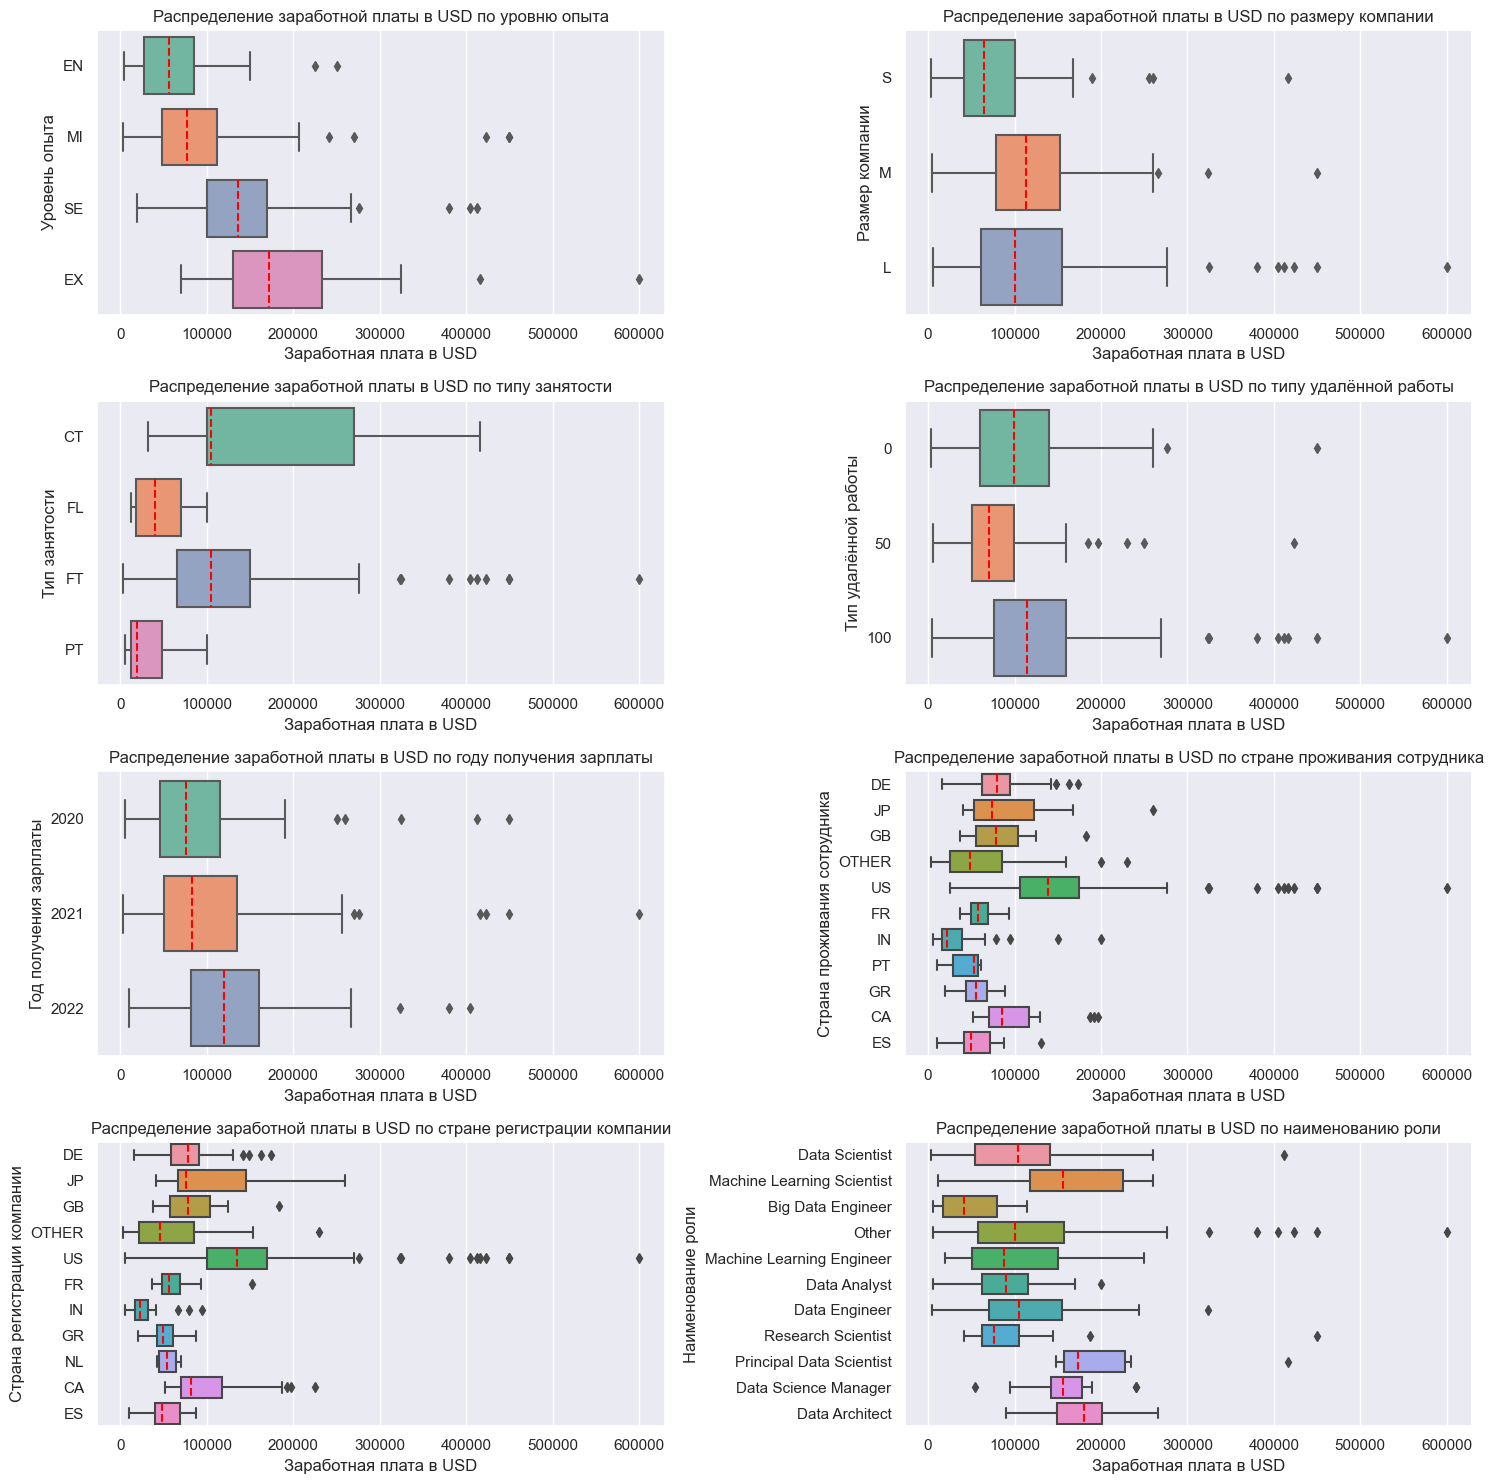

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0,0])
axes[0,0].set(xlabel='Заработная плата в USD', ylabel='Уровень опыта')
axes[0,0].set_title('Распределение заработной платы в USD по уровню опыта')

sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0,1])
axes[0,1].set(xlabel='Заработная плата в USD', ylabel='Размер компании')
axes[0,1].set_title('Распределение заработной платы в USD по размеру компании')

sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1,0])
axes[1,0].set(xlabel='Заработная плата в USD', ylabel='Тип занятости')
axes[1,0].set_title('Распределение заработной платы в USD по типу занятости')

sns.boxplot(data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1,1])
axes[1,1].set(xlabel='Заработная плата в USD', ylabel='Тип удалённой работы')
axes[1,1].set_title('Распределение заработной платы в USD по типу удалённой работы')

sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[2,0])
axes[2,0].set(xlabel='Заработная плата в USD', ylabel='Год получения зарплаты')
axes[2,0].set_title('Распределение заработной платы в USD по году получения зарплаты')

sns.boxplot(data, x='salary_in_usd', y='employee_residence_top_10', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[2,1])
axes[2,1].set(xlabel='Заработная плата в USD', ylabel='Страна проживания сотрудника')
axes[2,1].set_title('Распределение заработной платы в USD по стране проживания сотрудника')

sns.boxplot(data, x='salary_in_usd', y='company_location_top_10', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[3,0])
axes[3,0].set(xlabel='Заработная плата в USD', ylabel='Страна регистрации компании')
axes[3,0].set_title('Распределение заработной платы в USD по стране регистрации компании')

sns.boxplot(data, x='salary_in_usd', y='job_title_top_10', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[3,1])
axes[3,1].set(xlabel='Заработная плата в USD', ylabel='Наименование роли')
axes[3,1].set_title('Распределение заработной платы в USD по наименованию роли')

plt.tight_layout()
plt.show()

Основные выводы, которые можно сделать из этих диаграмм:
* Ожидаемо медианная зарплата растёт с увеличением уровня опыта;
* Зарплата больше в компаниях среднего (M) и крупного (L) размера, чем в небольших (S) (неожиданно в компаниях M даже больше, чем в L);
* Зарплаты у специалистов при полной занятости (FT) больше, чем при частичной (PT) и фрилансе (FL); что касается контракта (CT), то медиана здесь примерно совпадает с FT, однако распределение смещено в сторону более высоких зарплат. Это может объясняться тем, что особо квалифицированные специалисты предпочитают полной занятости работу по срочному контракту;
* Удалённый характер работы не оказывает однозначного влияния на медианную зарплату;
* С течением времени медианная зарплата ожидаемо растёт, в 2022 году рост ускорился;
* Сотрудники из США получают, а компании из США выплачивают наиболее высокие зарплаты;
* Наиболее высокие зарплаты получают специалисты на позициях Data Architect, Principal Data Scientist, Data Science Manager

### Предварительные ответы на вопросы исследования

Предварительно изучим данные в контексте заданных нам вопросов — пока не прибегая к методам статистического анализа:

* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [16]:
# Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
data_year_ds = data[data['job_title']=='Data Scientist'].groupby(by='work_year', observed=False, as_index=False)['salary_in_usd'].median()
data_year_ds.columns = ['work_year', 'median_salary']
data_year_ds

work_year  median_salary
0      2020        62726.0
1      2021        73000.0
2      2022       140000.0

Предварительно наблюдаем устойчивый рост зарплат специалистов Data Scientist (как и в целом по выборке — см. выше), который в 2022 году ускорился.

In [17]:
# Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
data_2022 = data[(data['work_year']==2022)&((data['job_title']=='Data Scientist')|(data['job_title']=='Data Engineer'))].groupby(by='job_title', observed=False, as_index=False)['salary_in_usd'].median()
data_2022.columns = ['job_title', 'salary_in_usd']
data_2022

job_title  salary_in_usd
0   Data Engineer       120000.0
1  Data Scientist       140000.0

Предварительно видим, что зарплаты Data Scientist превосходят зарплаты Data Engineer в 2022 году.

In [18]:
# Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
data_size = data[data['job_title']=='Data Scientist'].groupby(by='company_size', observed=False, as_index=False)['salary_in_usd'].median()
data_size.sort_values(by='company_size', inplace=True)
data_size.reset_index(drop=True, inplace=True)
data_size.columns = ['company_size', 'salary_in_usd']
data_size

company_size  salary_in_usd
0            S        49268.0
1            M       130000.0
2            L        90734.0

Как и в целом по выборке, видим, что зарплаты специалистов Data Scientist достигают максимума в компаниях среднего размера (M). Зарплаты в крупных компаниях (L) на втором месте, наименьшие зарплаты получают специалисты в небольших компаниях (S).

In [19]:
# Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
data_ds_de = data[((data['job_title']=='Data Scientist')|(data['job_title']=='Data Engineer'))]
data_cross = pd.crosstab(data_ds_de['company_size'], data_ds_de['job_title_top_10'])
data_cross

job_title_top_10  Data Engineer  Data Scientist
company_size                                   
S                             6              21
M                            89              77
L                            37              45

В компаниях небольшого размера (S) число специалистов Data Engineer в несколько раз меньше, чем Data Scientist. В компаниях среднего (M) и крупного (L) размера количество Data Engineer и Data Scientist выглядит сопоставимым.

## Статистический анализ данных

Проверим наши предварительные выводы с помощью методов статистического анализа.

In [20]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

Проверять будем распределение по всей выборке (без ограничения по году или роли, было бы странно, чтобы характер распределения менялся от года к году или от роли к роли).

In [101]:
# значения заработной платы в USD
data_salary = data.loc[:, 'salary_in_usd']

# проводим тест Шапиро-Уилка
result = stats.shapiro(data_salary)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

В нашей выборке представлены данные за три года (2020, 2021, 2022). Проведём отдельно сравнение 2020 и 2021, а затем 2021 и 2022 года для получения полной картины динамики зарплат.

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Сформулируем нулевую и альтернативные гипотезы 2020/2021**

*Нулевая гипотеза* ($H_0$): размер заработной платы в USD в 2021 году ($μ_1$) статистически меньше либо равен размеру заработной платы в USD в 2020 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в USD в 2021 году ($μ_1$) статистически больше, чем размер заработной платы в USD в 2020 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проведём тест 2020/2021**

In [48]:
data_ds_2020 = data.loc[(data['job_title']=='Data Scientist')&(data['work_year']==2020), 'salary_in_usd']
data_ds_2021 = data.loc[(data['job_title']=='Data Scientist')&(data['work_year']==2021), 'salary_in_usd']

# проводим тест
_, p = stats.mannwhitneyu(data_ds_2021, data_ds_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.685
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Сформулируем нулевую и альтернативные гипотезы 2021/2022**

*Нулевая гипотеза* ($H_0$): размер заработной платы в USD в 2022 году ($μ_1$) статистически меньше либо равен размеру заработной платы в USD в 2021 году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в USD в 2022 году ($μ_1$) статистически больше, чем размер заработной платы в USD в 2021 году ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проведём тест 2021/2022**

In [46]:
data_ds_2021 = data.loc[(data['job_title']=='Data Scientist')&(data['work_year']==2021), 'salary_in_usd']
data_ds_2022 = data.loc[(data['job_title']=='Data Scientist')&(data['work_year']==2022), 'salary_in_usd']

# проводим тест
_, p = stats.mannwhitneyu(data_ds_2022, data_ds_2021, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Итого, по данным статистического анализа:
* В 2021 году *не наблюдался* статистически значимый рост зарплат специалистов Data Scientist по сравнению с 2020 годом
* В 2022 году *наблюдался* статистически значимый рост зарплат специалистов Data Scientist по сравнению с 2021 годом

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы в USD в 2022 году специалистов Data Scientist ($μ_1$) и Data Engineer ($μ_2$) совпадает.

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в USD в 2022 году специалистов Data Scientist ($μ_1$) и Data Engineer ($μ_2$) не совпадает.

$$ H_1 : μ_1 ≠ μ_2$$

**Проведём тест**

In [50]:
data_ds_2022 = data.loc[(data['job_title']=='Data Scientist')&(data['work_year']==2022), 'salary_in_usd']
data_de_2022 = data.loc[(data['job_title']=='Data Engineer')&(data['work_year']==2022), 'salary_in_usd']

# проводим тест
_, p = stats.mannwhitneyu(data_ds_2022, data_de_2022)
decision_hypothesis(p)

p-value = 0.155
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Итого, по данным статистического анализа *не наблюдается* статистически значимых различий в зарплатах DS и DE в 2022 году.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Для начала используем критерий Краскела — Уоллиса, чтобы сравнить сразу три группы (S, M, L). Если статистически значимых отличий не будет обнаружено, дальнейший анализ можно не проводить.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы в USD специалистов Data Scientist совпадает в компаниях небольшого ($μ_1$), среднего ($μ_2$) и крупного размера ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 $$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в USD специалистов Data Scientist не совпадает в компаниях небольшого ($μ_1$), среднего ($μ_2$) и крупного размера ($μ_3$).

$$ H_1 : μ_1 ≠ μ_2 ≠ μ_3$$

**Проведём тест**

In [56]:
data_ds_s = data.loc[(data['job_title']=='Data Scientist')&(data['company_size']=='S'), 'salary_in_usd']
data_ds_m = data.loc[(data['job_title']=='Data Scientist')&(data['company_size']=='M'), 'salary_in_usd']
data_ds_l = data.loc[(data['job_title']=='Data Scientist')&(data['company_size']=='L'), 'salary_in_usd']

# проводим тест
_, p = stats.kruskal(data_ds_s, data_ds_m, data_ds_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Итак, размеры заработной платы DS в команиях различного размера не равны. Используем U-критерий Манна — Уитни для попарного сравнения. Отметим, что из предварительного анализа складывается впечатление, что наибольшие зарплаты в средних (M) компаниях, зарплаты в крупных (L) — средние, а самые низкие — в небольших (S). Поэтому сравним сначала S/L, а затем L/M.

**Сформулируем нулевую и альтернативные гипотезы (S/L)**

*Нулевая гипотеза* ($H_0$): размер заработной платы в USD в крупных (L) компаниях ($μ_1$) статистически меньше либо равен размеру заработной платы в USD в небольших (S) компаниях ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в USD в крупных (L) компаниях ($μ_1$) статистически больше размера заработной платы в USD в небольших (S) компаниях ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проведём тест (S/L)**

In [61]:
data_ds_s = data.loc[(data['job_title']=='Data Scientist')&(data['company_size']=='S'), 'salary_in_usd']
data_ds_l = data.loc[(data['job_title']=='Data Scientist')&(data['company_size']=='L'), 'salary_in_usd']

# проводим тест
_, p = stats.mannwhitneyu(data_ds_l, data_ds_s, alternative='greater')
decision_hypothesis(p)

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Сформулируем нулевую и альтернативные гипотезы (L/M)**

*Нулевая гипотеза* ($H_0$): размер заработной платы в USD в средних (M) компаниях ($μ_1$) статистически меньше либо равен размеру заработной платы в USD в крупных (L) компаниях ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы в USD в средних (M) компаниях ($μ_1$) статистически больше размера заработной платы в USD в крупных (L) компаниях ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проведём тест (L/M)**

In [62]:
data_ds_m = data.loc[(data['job_title']=='Data Scientist')&(data['company_size']=='M'), 'salary_in_usd']
data_ds_l = data.loc[(data['job_title']=='Data Scientist')&(data['company_size']=='L'), 'salary_in_usd']

# проводим тест
_, p = stats.mannwhitneyu(data_ds_m, data_ds_l, alternative='greater')
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Итого, мы получили подтверждение выводов предварительного анализа:
* Наибольшая заработная плата специалистам Data Scientist выплачивается в средних (M) компаниях
* В крупных (L) компаниях они могут претендовать на более низкую зарплату
* Самые низкие зарплаты в небольших (S) компаниях

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Для ответа на этот вопрос используем критерий хи-квадрат, поскольку нас интересует зависимость между двумя категориальными признаками — размером компании и должностью (с ограничением по двум должностям — Data Scientist и Data Engineer). Такую таблицу *data_cross* мы уже строили в рамках предварительного анализа.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): признаки *company_size* и *job_title* независимы

*Альтернативная гипотеза* ($H_1$): признаки *company_size* и *job_title* взаимосвязаны

**Проведём тест**

In [63]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(data_cross)
decision_hypothesis(p)


p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Итого, признак «Размер компании» и наличие должностей Data Scientist / Data Engineer взаимосвязаны.

## Дополнительные исследования

В рамках изучения других зависимостей проверим ещё три гипотезы:
1. Согласно открытым данным медианная годовая зарплата в сфере IT в США (то есть, для компаний, зарегистрированных в США) составила 100500 USD. Интересно проверить, будет ли зарплата специалистов Data Scientist за 2022 год больше медианной в целом по отрасли?
2. Из предварительного анализа очевидно, что в США зарплаты самые высокие. Однако что влияет больше — страна регистрации компании или страна проживания сотрудника?
3. Есть ли зависимость между страной регистрации компании и основной страной проживания сотрудника для удалённых работников? Понятно, что для большинства тех, кто должен ходить в офис, страны будут совпадать, а вот для удалёнщиков такая зависимость не очевидна. Проверим её.

### Превышает ли зарплата специалистов Data Scientist в американских компаниях в 2022 году медианную зарплату по всей IT-отрасли?

Для ответа на этот вопрос используем критерий знаков. Правда, поскольку этот критерий изначально только сравнивает медиану выборки с заданным значением, не отвечая на вопрос "больше" или "меньше", мы дополнительно используем знак тестовой статистики для получения точного ответа.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): медианная заработная плата специалистов Data Scientist в американских компаниях в 2022 году ($μ$) меньше или равна 100500 USD

$$ H_0 : μ <= 100500$$

*Альтернативная гипотеза* ($H_1$): медианная заработная плата специалистов Data Scientist в американских компаниях в 2022 году ($μ$) больше 100500 USD

$$ H_1 : μ > 100500$$

**Проведём тест**

In [ ]:
from statsmodels.stats.descriptivestats import sign_test

data_usd_ds_2022 = data.loc[(data['job_title']=='Data Scientist')&(data['work_year']==2022)&(data['company_location']=='US'), 'salary_in_usd']

# проводим тест
test_stat, p_value_two_sided = sign_test(data_usd_ds_2022, 100500)

# преобразуем полученное двустороннее p-значение в одностороннее с учётом знака тестовой статистики
p_value_one_sided = p_value_two_sided / 2 if test_stat > 0 else 1 - p_value_two_sided / 2

decision_hypothesis(p_value_one_sided)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Итого, медианная зарплата специалистов Data Scientist в 2022 году в США была выше медианной по IT-отрасли в целом. Отметим, что визуально эта гипотеза также подтверждается: медиана нашей выборки значительно выше установленной отметки в 100500 USD:

In [90]:
data_usd_ds_2022.median()

140850.0

### Какие зарплаты выше — у сотрудников из США или в американских компаниях?

Используем U-критерий Манна — Уитни для сравнения двух выборок. Мы будем полагать их независимыми, хотя они, очевидно, частично пересекаются — но не полностью.

**Сформируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): медианный размер заработной платы в USD для сотрудников из США ($μ_1$) равен медианному размеру заработной платы в USD для сотрудников компаний, зарегистрированных в США ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): медианный размер заработной платы в USD для сотрудников из США ($μ_1$) не равен медианному размеру заработной платы в USD для сотрудников компаний, зарегистрированных в США ($μ_2$).

$$ H_1 : μ_1 ≠ μ_2$$

**Проведём тест**

In [95]:
data_usa_residence = data.loc[data['employee_residence']=='US', 'salary_in_usd']
data_usa_location = data.loc[data['company_location']=='US', 'salary_in_usd']

# проводим тест
_, p = stats.mannwhitneyu(data_usa_residence, data_usa_location)
decision_hypothesis(p)

p-value = 0.296
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Итого, медианные зарплаты как для сотрудников из США, так и для сотрудников американских компаний статистически равны. Отметим, что и визуальное сравнение показывает, что медианы наших выборок очень близки:

In [93]:
display(data_usa_residence.median())
display(data_usa_location.median())

138475.0

135000.0

### Есть ли зависимость между страной регистрации компании и основной страной проживания сотрудника для удалённых работников?

Здесь снова используем критерий хи-квадрат, поскольку нам надо исследовать связь категориальных признаков.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): признаки *employee_residence* и *company_location* независимы

*Альтернативная гипотеза* ($H_1$): признаки *employee_residence* и *company_location* взаимосвязаны

**Проведём тест**

In [89]:
data_remote = data[data['remote_ratio']==100]
data_remote_cross = pd.crosstab(data_remote['employee_residence'], data_remote['company_location'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(data_remote_cross)
decision_hypothesis(p)


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Итого, признаки «Страна проживания сотрудника» и «Страна главного офиса работодателя» взаимосвязаны даже для удалённых работников.

## Итоговые результаты исследования

**Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

* В 2021 году *не наблюдался* статистически значимый рост зарплат специалистов Data Scientist по сравнению с 2020 годом
* В 2022 году *наблюдался* статистически значимый рост зарплат специалистов Data Scientist по сравнению с 2021 годом

**Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?**

По данным статистического анализа *не наблюдается* статистически значимых различий в зарплатах Data Scientist и Data Engineer в 2022 году.

**Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**

* Наибольшая заработная плата специалистам Data Scientist выплачивается в средних (M) компаниях
* В крупных (L) компаниях они могут претендовать на более низкую зарплату
* Самые низкие зарплаты в небольших (S) компаниях

**Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?**

Признак «Размер компании» и наличие должностей Data Scientist / Data Engineer взаимосвязаны.

**Дополнительно: превышает ли медианная зарплата Data Scientist в 2022 году в США медианную по отрасли (100500 USD)?**

Да, медианная зарплата Data Scientist в 2022 году в США первышает медианную по отрасли (100500 USD).

**Дополнительно: различается ли медианная зарплата для сотрудников из США и для сотрудников американских компаний?**

Нет, различия между медианной зарплатой сотрудников из США и сотрудников американских компаний статистически не значимы.

**Дополнительно: сохраняется ли взаимосвязь между страной проживания сотрудника и страной регистрации работодателя для сотрудников на полной удалёнке?**

Да, взаимосвязь между страной проживания сотрудника и страной регистрации работодателя сохраняется даже для полностью удалённых работников.